In [3]:
import matplotlib.pyplot as plt

import utils.gol as gol
import numpy as np
gol._init()
gol.set_value('device', 'cuda:1')
from environments.mujoco.ant_goal_cluster import AntGoalClusterEnv
from environments.mujoco.ant_goal import AntGoalEnv

----------------------------------------------------------------------------------------------------


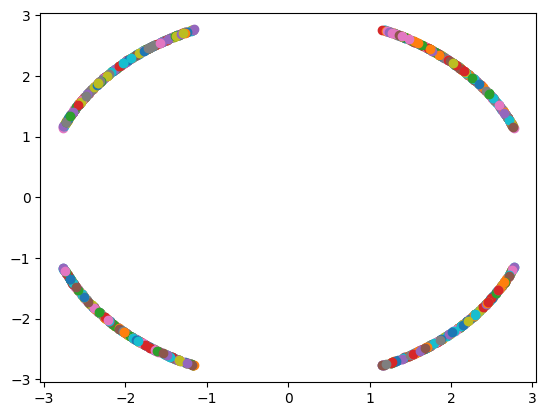

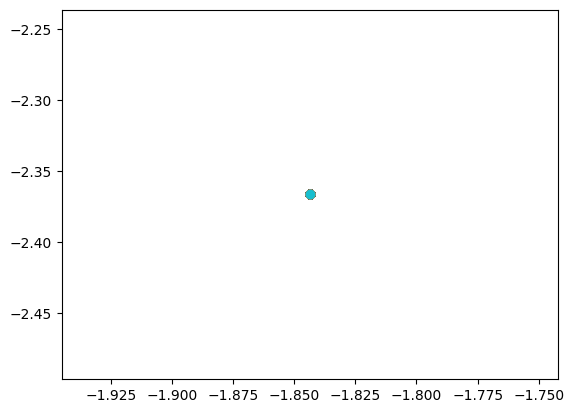

In [4]:
plt.figure()

env = AntGoalClusterEnv()
for i in range(1000):
    env.reset_task(task=None)
    plt.scatter(*env.get_task())
    # print(np.sum(np.square(env.get_task())))

print('-' * 100)

plt.figure()
test_env = AntGoalEnv()

for i in range(1000):
    test_env.reset_task(task=None)
    plt.scatter(*env.get_task())
    # print(test_env.get_task())


In [5]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

list(mcolors.BASE_COLORS.keys())

['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

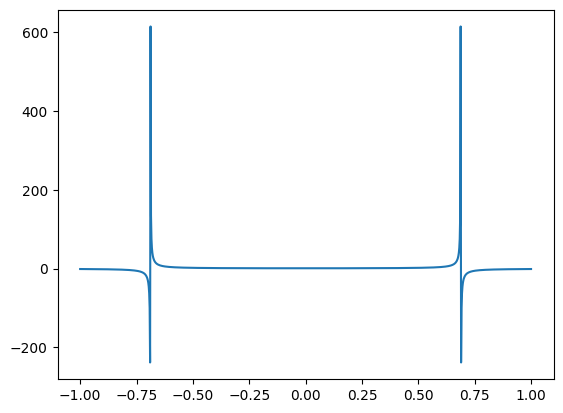

In [9]:
import numpy as np
def long_tail_sigmoid(x):
    return 1 / ((1 / (0.1 - 1) - 1) * np.square(x) + 1)

x = np.linspace(-1, 1, 1000)
y = long_tail_sigmoid(x)
plt.plot(x, y)